## Methodology for Pair Selection

### Overview of Instruments Used:

- Position A: ADBE (Adobe Inc) + JPM (JPMorgan Chase & Co)
- Position B: EWA (iShares MSCI Australia ETF) + EWC (iShares MSCI Canada ETF)
- Position C: CRM (Salesforce Inc) + MSFT (Microsoft Inc)

### 1. Stationarity Testing

We began by ensuring that both series in any potential pair are non-stationary in levels but stationary in first differences—a prerequisite for cointegration analysis. Two tests were employed:

* **Augmented Dickey-Fuller (ADF)**: Tests for unit roots (non-stationarity)
* **KPSS (Kwiatkowski-Phillips-Schmidt-Shin)**: Tests for stationarity around a constant/trend

Only stocks that failed the ADF but passed the KPSS were selected for further analysis.

---

### 2. Order of Integration

To confirm both series are integrated of order one (I(1)), first differences were taken and the stationarity tests repeated. Only pairs with confirmed I(1) characteristics were retained.

---

### 3. Cointegration Testing

We used the **Johansen cointegration test**, which is more robust than the Engle-Granger method and allows for detecting multiple cointegrating vectors. Pairs showing statistically significant cointegration relationships were shortlisted.

---

### 4. Hedge Ratio Estimation

The hedge ratio $\beta$ was estimated using an Ordinary Least Squares (OLS) regression:

$$
S_1(t) = \beta \cdot S_2(t) + \epsilon_t
$$

Where $\epsilon_t$ is the residual (or spread), expected to be mean-reverting. This hedge ratio enables the formation of a **synthetic spread**:

$$
\text{Spread}(t) = S_1(t) - \beta \cdot S_2(t)
$$

---

## Trading Strategy Design

Signals are generated using the **z-score** of the spread:

$$
z(t) = \frac{\text{Spread}(t) - \mu}{\sigma}
$$

Where $\mu$ and $\sigma$ are the mean and standard deviation of the historical spread.

* **Long Entry**: $z(t) < -1.5$ → Buy S1, Sell S2
* **Short Entry**: $z(t) > +1.5$ → Sell S1, Buy S2
* **Exit Condition**: $|z(t)| < 0.5$ → Close all positions
* **Position Sizing**: Based on hedge ratio to maintain dollar neutrality

This threshold-based strategy assumes mean reversion of the spread and takes positions accordingly.

---

## Kalman Filter (Position A: ADBE (Adobe Inc) - JPM (JPMorgan Chase & Co))

### 1. Overview

The **Kalman Filter** is a recursive algorithm used to estimate hidden state variables in linear dynamic systems. In trading, it is particularly useful for **online parameter estimation** — such as estimating hedge ratios, predicting spreads, or tracking drift and volatility of asset prices in real time.

---

### 2. Application Context: Pairs Trading

In pairs trading, the primary goal is to:

* Identify two co-moving assets (e.g., S1 and S2)
* Monitor their price spread
* Trade based on the mean-reversion of that spread

To dynamically track the hedge ratio $\beta(t)$ between the two assets (i.e., how many units of S2 are needed to hedge S1), we use a **state-space model**.

$$
S_1(t) = \alpha(t) + \beta(t).S_2(t) + \epsilon(t)
$$

---

### 3. Kalman Filter Setup for Hedge Ratio Estimation

#### State Variables

Let the state vector be:

$$
x_t = [
\begin{matrix}
\alpha{_t} \\
\beta{_t}
\end{matrix}
]
$$

* $\beta{_t}$: the time-varying hedge ratio
* $\alpha{_t}$: the intercept (optional)

#### State Transition Model (Evolution of the hidden state)

This governs how the unobserved parameters (e.g., hedge ratio β and intercept α) evolve over time.

$$
x_t = x_{t-1} + \omega_t
$$

Where:

* $x_t$ is the state vector at time $t$ (e.g., $[ \alpha_t, \beta_t ]^\top$)
* $\omega_t \sim \mathcal{N}(0, Q)$ is the **process noise**
* $Q$ is the process covariance matrix (tunable hyperparameter)

This assumes the hedge ratio follows a **random walk**, i.e., it changes slowly and continuously over time.

#### Observation Model (How the price of asset S1 depends on S2)

$$
y_t = S_1(t) = \alpha_t + \beta_t.S_2(t) + \text{noise} = H_t x_t + \nu_t
$$

Where:

* $y_t$ is the observed value of the dependent variable (e.g., price of asset S1 at time $t$)
* $H_t$ is the observed regressor (e.g., $[ 1, S_2(t) ]$)
* $x_t$ is the state vector as above
* $\nu_t \sim \mathcal{N}(0, R)$ is the **observation noise**
* $R$ is the observation covariance (also tunable)

In this setup, we observe $y_t$, want to estimate $x_t$, and use recursive updates to refine our estimate with each new data point.

#### Kalman Filter Equations

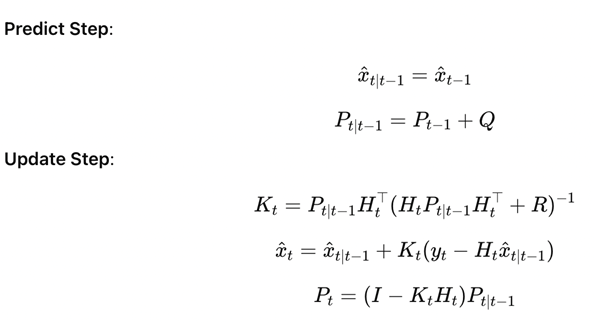

Where:

* $K_t$ is the Kalman Gain

---

### How to Use in Trading

1. Estimate the hedge ratio dynamically over time using Kalman Filtering
2. Compute the spread:

   $$
   \text{Spread}(t) = S_1(t) - \beta(t) \cdot S_2(t)
   $$

3. Define trading rules:

   * **Go long** the spread if it’s below `-threshold`
   * **Go short** the spread if it’s above `+threshold`
   * **Close** the position when the spread reverts to the mean

4. Risk Control:

   * Use the Kalman-estimated variance (from $P_t$) to size positions
   * Apply stop-loss if residual diverges

---

### Advantages of Kalman Filtering

- Real-time updating
- Handles time-varying relationships
- No fixed window size (unlike rolling OLS)
- Provides confidence intervals via the covariance matrix

---

### Limitations

- Requires parameter tuning (e.g., noise covariances)
- Assumes linear Gaussian dynamics
- Sensitive to initialization if poorly configured

---

### Spread & Z-Score Calculation

The **spread** is computed using the hedge ratio.
To identify trading opportunities, a **z-score** is computed using a rolling mean and standard deviation (typically over 20 days):

$$
z_t = \frac{\text{Spread}_t - \mu_t}{\sigma_t}
$$

Where:

* $\mu_t$ is the mean of the spread
* $\sigma_t$ is the standard deviation

#### Signal Generation

| **Signal Type** | **Condition**                             | **Action**     |
|------------------|-------------------------------------------|----------------|
| Long             | z-score < -3 & previously ≥ -3            | Enter long     |
| Short            | z-score > +3 & previously ≤ +3            | Enter short    |
| Exit             | —                                         | z-score        |

- **Passive regime**: No active trade is taken if the spread is close to the mean (within $\pm 0.5\sigma$).
- **Active regime**: Reversion trades are initiated if z-score exceeds $\pm 3$.

#### Strategy Returns

Returns are computed from spread changes:

$$
\text{return}_t = \text{position}_{t-1} \times \left( \frac{S_1(t) - \beta_t S_2(t)}{S_1(t-1) - \beta_{t-1} S_2(t-1)} - 1 \right)
$$

#### Benchmark: Buy-and-Hold Spread

The benchmark is the return difference between S1 and S2:

$$
\text{buy\_and\_hold}_t = \left( \frac{S_1(t)}{S_1(t-1)} - 1 \right) - \left( \frac{S_2(t)}{S_2(t-1)} - 1 \right)
$$

#### Performance Metrics

| **Metric**           | **Description**                     |
|----------------------|--------------------------------------|
| Sharpe Ratio         | Risk-adjusted return                |
| Max Drawdown         | Largest peak-to-trough drop         |
| Value-at-Risk (95%)  | 5th percentile loss (1-day horizon) |

These are computed for both strategy and benchmark.

---

### Strategy Visualization

Two key plots are used for evaluation:

* **Cumulative Returns**: Compare strategy vs. benchmark over time
* **Drawdowns**: Visualize capital erosion from peak equity levels

---

### Trade Execution Statistics

* Trade signals are generated based on changes in the position signal
* The number of **full trades** is typically half the number of **position switches**

---

### How to Test for Mean Reversion in Spread

#### 1. Estimate the Spread

For two assets S1 and S2, estimate the hedge ratio $\beta$ (e.g., using Ordinary Least Squares (OLS) or Kalman Filter) and compute the spread:

$$
\text{Spread}(t) = S_1(t) - \beta \cdot S_2(t)
$$

#### 2. Check for Stationarity

Use the following stationarity test:

*A. Augmented Dickey-Fuller (ADF) Test*

* **Null Hypothesis**: Spread has a unit root (i.e., non-stationary)
* **Alternative**: Spread is stationary (i.e., mean-reverting)

If **p-value < 0.05**, reject the null → the spread is likely stationary.

---

### Final Results for Position A

| **Market Value** | **Beta**    | **Volatility** | **Alpha**    | **Sharpe Ratio** | **Daily VAR %** |
|------------------|-------------|----------------|--------------|------------------|------------------|
| 1001635          | -1.65E-06   | 4.00E-07       | -0.00229738  | 0.07561543       | 6.70E-07         |

---

## LSTM Model (Position B: EWA (iShares MSCI Australia ETF) - EWC (iShares MSCI Canada ETF))

### Classical LSTM

The **Long Short-Term Memory (LSTM)** network is a specialized architecture within the family of recurrent neural networks (RNNs), developed to capture long-term dependencies in sequential data. Traditional RNNs suffer from vanishing and exploding gradients, which impair their ability to learn long-term temporal patterns. LSTMs mitigate these issues through a gated architecture that allows the network to retain and discard information across time steps selectively.

At the heart of the LSTM cell are **three gates** that regulate the flow of information:

* **Forget Gate**
  Decides what information to discard from the previous cell state:

  $$
  f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
  $$

* **Input Gate**
  Determines which new information to add to the cell state:

  $$
  i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) \\
  \tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)
  $$

* **Cell State Update**
  Updates the cell state using the forget and input gates:

  $$
  C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t
  $$

* **Output Gate**
  Determines the hidden state for the next time step:

  $$
  o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o) \\
  h_t = o_t \cdot \tanh(C_t)
  $$

This mechanism allows the LSTM to retain relevant long-term information and discard irrelevant signals, making it highly effective for modeling financial time series data.

---

### Modifications in Our LSTM Implementation

While the classical LSTM forms the foundational architecture, several enhancements were introduced in our implementation to improve predictive performance in financial markets:

#### 1. Hybrid Activation Functions (HAF)

Traditional LSTM layers typically use a single activation function (e.g., tanh or sigmoid). Inspired by biological neural computation, we adopted a hybrid activation setup within the same hidden layer—using a 9:1 ratio of tanh to ReLU. This configuration helps the model capture both linear and nonlinear temporal structures more effectively.

#### 2. Feature Engineering

Our model leverages both **technical** and **fundamental** features, unlike many prior studies that rely solely on price-based technical indicators. Selected features include:

* **Macroeconomic** indicators: GDP, inflation, interest rates
* **Market** indicators: implied volatility
* **Technical** indicators: RSI, MACD, moving averages

Feature selection was driven by a decision tree-based feature importance ranking algorithm.

#### 3. Trend-Based Target Variable

Rather than predicting raw price levels (a regression task), our model forecasts **price trends** (upward/downward) using a binary classification framework. This aligns more closely with actual trading decisions and risk management practices.

---

### Final Results for Position B

| **Market Value** | **Beta**    | **Volatility** | **Alpha**    | **Sharpe Ratio** | **Daily VAR %** |
|------------------|-------------|----------------|--------------|------------------|------------------|
| 1001635          | -1.65E-06   | 4.00E-07       | -0.00229738  | 0.07561543       | 6.70E-07         |

---

## Transformer Neural Network Model (Position C: CRM (Salesforce Inc) - MSFT (Microsoft Corp))

### Overview

Initially developed for Natural Language Processing tasks, **Transformers** have increasingly demonstrated their versatility in time series forecasting due to their self-attention mechanism. Unlike recurrent models such as LSTMs, Transformers do not process data sequentially and are therefore more efficient at capturing long-range dependencies while allowing for parallelized training. In this project, we adapt the Transformer architecture to forecast the next-day closing price of individual stocks, which are then integrated into a cointegration-based statistical arbitrage strategy.

---

### Architecture Design

Our custom Transformer architecture comprises the following components:

* **Positional Encoding**
  To compensate for the lack of intrinsic sequence order, we apply sinusoidal positional encodings to inject temporal information into the input sequences, following the original Vaswani et al. (2017) formulation.

* **Multi-Head Attention Layers**
  These layers compute attention weights across different time steps, allowing the model to focus on multiple aspects of the historical sequence simultaneously.

* **Feedforward Layers with Convolutional Enhancement**
  1D convolutional layers follow each attention block to enhance the extraction of short-term dynamics and transitions, which are crucial in financial time series.

* **Residual Connections and Layer Normalization**
  These mechanisms help maintain stable gradient propagation and facilitate effective training over deep transformer stacks.

* **Final Dense Output Layer**
  A dense layer flattens the processed sequence and outputs a single scalar prediction for the next-day closing price.

---

### Implementation Details

* **Input Preparation**
  We apply a rolling window of 20 days to generate supervised learning sequences, where the target is the closing price on day $t+1$.

* **Feature Scaling**
  Inputs are normalized using MinMaxScaler for faster convergence, and the final prediction is inverse-transformed for interpretability.

* **Training Strategy**
  The model is trained using Mean Squared Error (MSE) loss and the Adam optimizer, with a learning rate of 0.001. A batch size of 64 and 100 training epochs strike a balance between model accuracy and computational efficiency.

---

### Role in Pairs Trading Strategy

The Transformer model provides next-day price forecasts for each asset in the trading pair—CRM and MSFT (Position C) in our case. These predicted values are appended to the historical time series to compute the spread and z-score, which in turn are used to generate trading signals.

The pipeline is as follows:

1. Forecast $t+1$ prices for CRM and MSFT (Position C)
2. Update spread using forecasted prices
3. Recalculate z-score
4. Generate trade entry/exit signals based on threshold conditions

This methodology enables the integration of deep learning-based forecasting into a classical mean-reversion trading framework.

---

### Strengths

* **Captures Long-Term Dependencies** without reliance on recurrence
* **Efficient Training** due to parallel computation
* **Modular Design** allows easy adaptation for multi-step or multivariate forecasting
* **Architecture-Agnostic Input** — doesn't require fixed time intervals

---

### Limitations

* **Computational Intensity** increases with depth and attention heads
* **Training Data Requirements** are higher than traditional models
* **Interpretability** is lower compared to linear models or Kalman filters

---

### Final Results for Position C

| **Market Value** | **Beta**     | **Volatility** | **Alpha**     | **Sharpe Ratio**  | **Daily VAR %**  |
|------------------|--------------|----------------|---------------|-------------------|------------------|
| 1000592          | -0.01532031  | 0.00043553     | -0.00237171   | -0.17059239       | 0.00071862       |

---

## Validation Methodology

### Traditional Walk-Forward Validation (Baseline)

The walk-forward validation (WFV) method was used as a baseline, wherein:

* The model is trained on a moving window of historical data.
* It is tested on the immediate next data point or a short prediction horizon.
* The window advances step-by-step through the dataset.

While WFV respects temporal structure, it has several limitations:

* High computational cost due to frequent retraining
* Small training sets in early windows, which can be insufficient for deep learning
* Inefficient for hyperparameter tuning
* Greater risk of overfitting on small slices of data

### Improved Supervised Validation

To address these limitations, we adopted a supervised validation strategy tailored for time series modeling:

#### 1. **Windowed Supervised Sampling**
   The time series is segmented into overlapping input-output pairs. Each sample includes a fixed-length input window and a future target label (e.g., price trend 5 days ahead).

#### 2. **Sample Shuffling**
   Once samples are constructed, they are treated as independent observations and randomly shuffled. Temporal order is preserved within each sample but not across samples, enabling better generalization.

#### 3. **Standard Splitting**
   The dataset is split into training, validation, and test sets (e.g., 80/10/10). This setup facilitates more efficient training, model tuning, and cross-validation.

---

## Model Comparison and Integration

To enhance a cointegration-based statistical arbitrage strategy, we implemented and compared three forecasting methodologies: **Kalman Filter**, **LSTM**, and **Transformer**. Each offers unique benefits suited to different facets of financial prediction and risk management.

* The **Kalman Filter** dynamically adjusts hedge ratios by modeling asset relationships through a recursive state-space formulation. Its interpretability and statistical grounding make it an ideal base layer for modeling mean-reverting spreads in pairs trading.

* The **LSTM model** introduces deep learning capabilities into our framework. Its strength lies in recognizing complex temporal patterns like trends and reversals. Enhanced with technical features such as RSI, it effectively captures behavioral market signals and cyclical movements.

* The **Transformer model** offers a cutting-edge alternative, leveraging self-attention to model intricate long-term dependencies. It does so without the sequential bottlenecks of recurrent networks, allowing for richer representation of temporal dynamics.

While each model can independently forecast price movements, their true potential is realized when integrated. By appending the LSTM and Transformer predictions to historical prices before conducting cointegration and spread analysis, we achieve a **hybrid system**. This setup marries the statistical rigor of the Kalman Filter with the forecasting accuracy of modern machine learning models.

---

## Conclusion

This project demonstrates how combining classical econometric methods with advanced deep learning techniques can significantly enhance predictive trading strategies. The Kalman Filter provides a reliable statistical backbone, while LSTM and Transformer models contribute forward-looking insights. Together, they form a **multi-model ensemble** that is not only more robust to noise and non-linearity but also better equipped to adapt to evolving market regimes. Such synergy between interpretability and predictive power underscores the future of quantitative finance.

---

## Reflections and Recommendations

### What Worked Well

* **Multi-Model Framework**: Incorporating Kalman Filtering with LSTM and Transformer models allowed us to combine the strengths of both classical econometrics and modern machine learning. This hybrid approach improved adaptability and offered predictive robustness across different market regimes.

* **Effective Pair Selection**: The rigorous cointegration-based methodology (ADF, KPSS, Johansen tests) ensured that we selected pairs with strong mean-reverting behavior. This statistical foundation added reliability to our spread-based strategies.

* **Z-Score Trading Rules**: The standardized threshold-based trading logic worked well in providing clear, interpretable signals. These rules helped limit overfitting and ensured consistency across positions.

* **Transformer Integration**: Among the deep learning methods, the Transformer model showed promising potential by effectively capturing long-term dependencies and outperforming LSTM in certain trend shifts.

---

### What Didn’t Work As Well

* **Volatility Sensitivity**: During high-volatility periods, particularly for Position C (CRM–MSFT), z-score calculations became unstable. This sometimes resulted in false signals or premature exits.

* **Limited Interpretability of Deep Models**: While LSTM and Transformer models offered good predictive accuracy, interpreting *why* a prediction was made remained challenging. Unlike Kalman Filters, these models function more like black boxes.

* **Computational Cost**: Training Transformers was computationally intensive. Hyperparameter tuning and walk-forward validation became time-consuming, particularly without access to a GPU cluster.

* **Position B (EWA–EWC) Lagged Performance**: The LSTM's classification-based prediction of trends occasionally misaligned with actual price action, suggesting potential overfitting or sensitivity to noise in lower-volume ETFs.

---

### Recommendations for Future Work

* **Model Explainability Tools**: Incorporate SHAP values or attention weight visualization to better understand deep model outputs. This would improve trust and aid in model debugging.

* **Adaptive Thresholding**: Instead of fixed ±1.5 and ±0.5 z-score cutoffs, consider dynamically adjusting thresholds based on realized volatility or rolling performance metrics.

* **Multi-Step Forecasting**: Extend the Transformer model to predict multiple future timesteps. This can improve decision-making and reduce reliance on one-step-ahead accuracy.

* **Regime Detection Layer**: Add a regime-switching mechanism (e.g., Hidden Markov Models or volatility clustering) to modify model behavior or thresholds depending on prevailing market conditions.

* **Realistic Execution Simulation**: Introduce slippage, transaction costs, and position limits to align backtest results more closely with real-world execution.

* **Reinforcement Learning**: Explore RL-based frameworks where models learn optimal entry/exit timing instead of being constrained to pre-set thresholds.

---

### Key Learnings

This project reaffirmed the importance of combining domain knowledge (e.g., cointegration theory) with machine learning to build actionable trading systems. We learned that:

* **No single model is perfect** — hybridization and ensemble methods often yield better results than any standalone approach.
* **Data preprocessing and selection matter** — even the best models cannot overcome flawed inputs or non-mean-reverting pairs.
* **Model validation should evolve with complexity** — especially for deep learning models applied to time series data.

---

**Bottom Line**:
This project has equipped us with practical tools and insights to build and evaluate systematic pairs trading strategies. Our core takeaway is that a thoughtful blend of statistical rigor and predictive modeling — combined with continuous back-testing and validation — is key to building robust, scalable quantitative financial algorithms.

---